## Importing required Python Packages and Libraries

In [130]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
std=StandardScaler()

In [2]:
covid=pd.read_csv("covid_19_data.csv")
covid.head()

SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0

In [3]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (27618, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     14187
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [4]:
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["SNo"],1,inplace=True)

In [5]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

## Datewise analysis 

In [6]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [7]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  223
Total number of Confirmed Cases around the World:  5102424.0
Total number of Recovered Cases around the World:  1948739.0
Total number of Deaths Cases around the World:  332924.0
Total number of Active Cases around the World:  2820761.0
Total number of Closed Cases around the World:  2281663.0
Approximate number of Confirmed Cases per Day around the World:  42169.0
Approximate number of Recovered Cases per Day around the World:  16105.0
Approximate number of Death Cases per Day around the World:  2751.0
Approximate number of Confirmed Cases per hour around the World:  1757.0
Approximate number of Recovered Cases per hour around the World:  671.0
Approximate number of Death Cases per hour around the World:  115.0
Number of Confirmed Cases in last 24 hours:  105952.0
Number of Recovered Cases in last 24 hours:  51273.0
Number of Death Cases in last 24 hours:  4809.0


In [8]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

#### Active Cases = Number of Confirmed Cases - Number of Recovered Cases - Number of Death Cases
#### Increase in number of Active Cases is probably an indication of Recovered case or Death case number is dropping in comparison to number of Confirmed Cases drastically. Will look for the conclusive evidence for the same in the notebook ahead.

In [9]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

#### Closed Cases = Number of Recovered Cases + Number of Death Cases 
#### Increase in number of Closed classes imply either more patients are getting recovered from the disease or more pepole are dying because of COVID-19

In [10]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

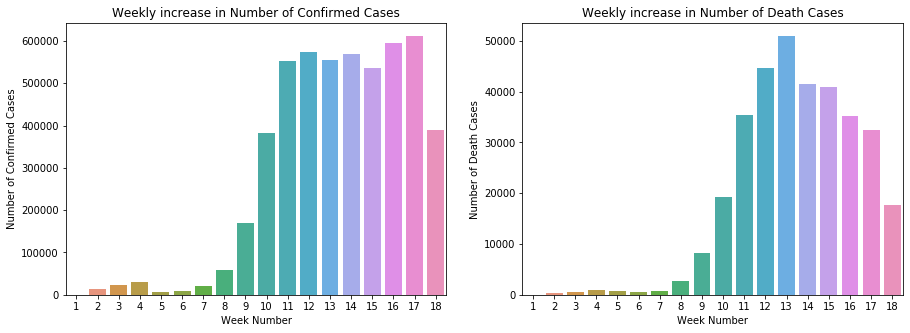

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

#### Growth rate of Confirmed, Recovered and Death Cases 

In [12]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### Moratality and Recovery Rate analysis around the World

In [13]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 4.634959561067193
Median Mortality Rate 4.33759885145437
Average Recovery Rate 26.956711907850366
Median Recovery Rate 26.68848454728338


#### Mortality rate = (Number of Death Cases / Number of Confirmed Cases) x 100
#### Recovery Rate= (Number of Recoverd Cases / Number of Confirmed Cases) x 100
#### Mortality rate is showing a considerable for a pretty long time, which is positive sign
#### Recovery Rate has started to pick up again which is a good sign, another supportive reason to why number of Closed Cases are increasing

In [14]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  42164.0
Average increase in number of Recovered Cases every day:  16105.0
Average increase in number of Deaths Cases every day:  2751.0


### Growth Factor
Growth factor is the factor by which a quantity multiplies itself over time. The formula used is:

**Formula: Every day's new (Confirmed,Recovered,Deaths) / new (Confirmed,Recovered,Deaths) on the previous day.**

A growth factor **above 1 indicates an increase correspoding cases**.

A growth factor **above 1 but trending downward** is a positive sign, whereas a **growth factor constantly above 1 is the sign of exponential growth**.

A growth factor **constant at 1 indicates there is no change in any kind of cases**.

In [15]:
print("Average growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).median())
print("Average growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).mean())
print("Median growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).median())
print("Average growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).mean())
print("Median growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).median())

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"]/datewise["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"]/datewise["Recovered"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"]/datewise["Deaths"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Average growth factor of number of Confirmed Cases:  1.0845552277614687
Median growth factor of number of Confirmed Cases:  1.038949398406392
Average growth factor of number of Recovered Cases:  1.1029236174537693
Median growth factor of number of Recovered Cases:  1.0607800188084515
Average growth factor of number of Death Cases:  1.0902691307536612
Median growth factor of number of Death Cases:  1.060665830894092


#### Growth Factor for Active and Closed Cases
Growth factor is the factor by which a quantity multiplies itself over time. The formula used is:

**Formula: Every day's new (Active and Closed Cases) / new (Active and Closed Cases) on the previous day.**

A growth factor **above 1 indicates an increase correspoding cases.**

A growth factor **above 1 but trending downward is a positive sign.**

A growth factor **constant at 1 indicates there is no change in any kind of cases.**

A growth factor **below 1 indicates real positive sign implying more patients are getting recovered or dying as compared to the Confirmed Cases.**

In [16]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, 
                         y=(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])/(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Active Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Recovered"]+datewise["Deaths"])/(datewise["Recovered"]+datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed Cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

#### Growth Factor constantly above 1 is an clear indication of Exponential increase in all form of cases.

### Rate of Doubling for Confirmed Cases around the World

In [17]:
c=1000
double_days=[]
C=[]
while(1):
    double_days.append(datewise[datewise["Confirmed"]<=c].iloc[[-1]]["Days Since"][0])
    C.append(c)
    c=c*2
    if(c<datewise["Confirmed"].max()):
        continue
    else:
        break

In [18]:
doubling_rate=pd.DataFrame(list(zip(C,double_days)),columns=["No. of cases","Days since first Case"])
doubling_rate["Number of days for doubling"]=doubling_rate["Days since first Case"].diff().fillna(doubling_rate["Days since first Case"])
doubling_rate

No. of cases Days since first Case Number of days for doubling
0           1000                2 days                      2 days
1           2000                3 days                      1 days
2           4000                5 days                      2 days
3           8000                7 days                      2 days
4          16000               10 days                      3 days
5          32000               15 days                      5 days
6          64000               22 days                      7 days
7         128000               49 days                     27 days
8         256000               57 days                      8 days
9         512000               63 days                      6 days
10       1024000               71 days                      8 days
11       2048000               83 days                     12 days
12       4096000              108 days                     25 days

#### Doubling Rate is fluctuating very much, which ideally supposed to increase if we are successfully faltening the curve.

### Number of days requried for increase in Confirmed Cases by 200K

In [19]:
c1=100000
days_200k=[]
C1=[]
while(1):
    days_200k.append(datewise[datewise["Confirmed"]<=c1].iloc[[-1]]["Days Since"][0])
    C1.append(c1)
    c1=c1+200000
    if(c1<datewise["Confirmed"].max()):
        continue
    else:
        break

In [20]:
rate_200k=pd.DataFrame(list(zip(C1,days_200k)),columns=["No. of Cases","Days Since first Case"])
rate_200k["Days requried for rise of 200K"]=rate_200k["Days Since first Case"].diff().fillna(rate_200k["Days Since first Case"].iloc[[0]][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=rate_200k["No. of Cases"], y=rate_200k["Days requried for rise of 200K"].dt.days,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.update_layout(title="Number of Days required for increase in number of cases by 200K",
                 xaxis_title="Number of Cases",yaxis_title="Number of Days")
fig.show()

## Countrywise Analysis

In [21]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

Text(0.5, 1.0, 'Top 15 countries as per Number of Death Cases')

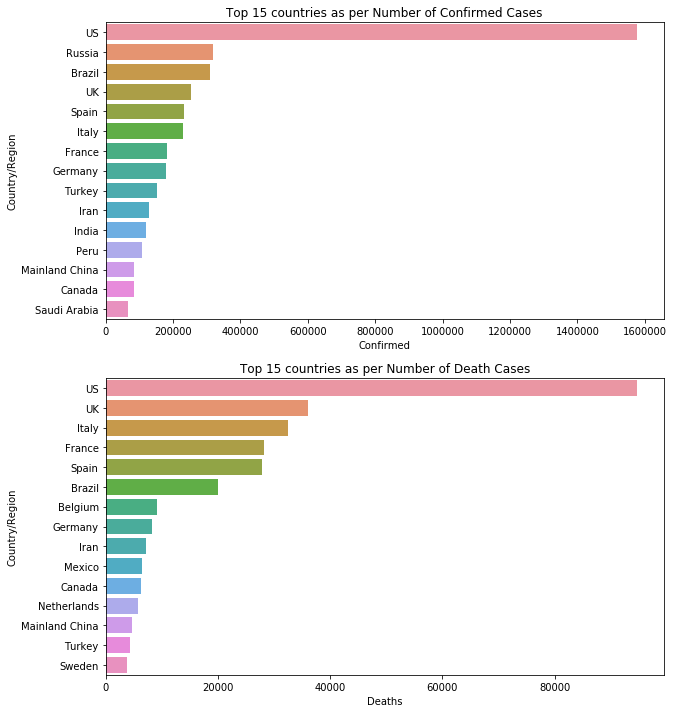

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 countries as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 countries as per Number of Death Cases")

#### Top 25 Countries as per Mortatlity Rate and Recovery Rate with more than 500 Confirmed Cases

Text(0.5, 0, 'Recovery (in Percentage)')

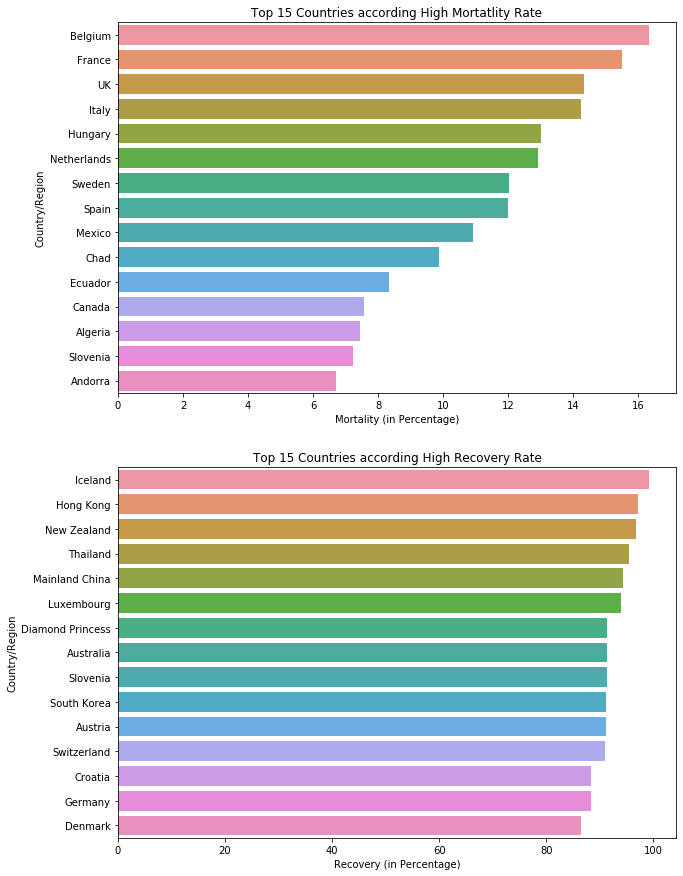

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise_plot_mortal=countrywise[countrywise["Confirmed"]>500].sort_values(["Mortality"],ascending=False).head(15)
sns.barplot(x=countrywise_plot_mortal["Mortality"],y=countrywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 15 Countries according High Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
countrywise_plot_recover=countrywise[countrywise["Confirmed"]>500].sort_values(["Recovery"],ascending=False).head(15)
sns.barplot(x=countrywise_plot_recover["Recovery"],y=countrywise_plot_recover.index, ax=ax2)
ax2.set_title("Top 15 Countries according High Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")

Text(0.5, 0, 'Recovery (in Percentage)')

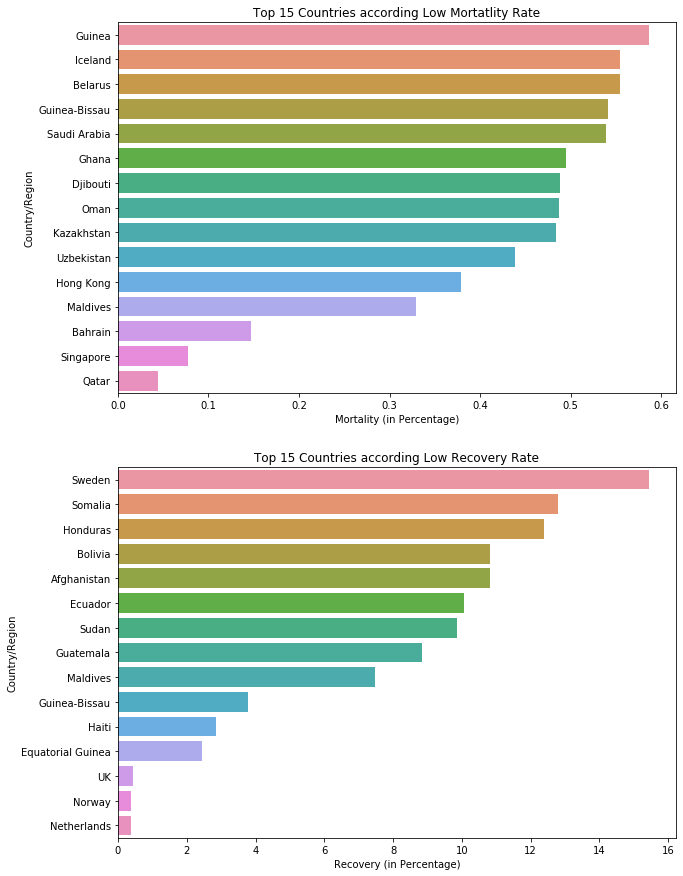

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise_plot_mortal=countrywise[countrywise["Confirmed"]>500].sort_values(["Mortality"],ascending=False).tail(15)
sns.barplot(x=countrywise_plot_mortal["Mortality"],y=countrywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 15 Countries according Low Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
countrywise_plot_recover=countrywise[countrywise["Confirmed"]>500].sort_values(["Recovery"],ascending=False).tail(15)
sns.barplot(x=countrywise_plot_recover["Recovery"],y=countrywise_plot_recover.index, ax=ax2)
ax2.set_title("Top 15 Countries according Low Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")

#### No Recovered Patients with considerable Mortality Rate

In [25]:
no_recovered_countries=countrywise[(countrywise["Recovered"]==0)][["Confirmed","Deaths"]]
no_recovered_countries["Mortality Rate"]=(no_recovered_countries["Deaths"]/no_recovered_countries["Confirmed"])*100
no_recovered_countries=no_recovered_countries[no_recovered_countries["Mortality Rate"]>0].sort_values(["Mortality Rate"],ascending=False)
no_recovered_countries.style.background_gradient('Reds')

#### Countries with more than 100 Confirmed Cases and No Deaths with considerably high Recovery Rate

In [26]:
no_deaths=countrywise[(countrywise["Confirmed"]>100)&(countrywise["Deaths"]==0)]
no_deaths=no_deaths[no_deaths["Recovery"]>0].sort_values(["Recovery"],ascending=False).drop(["Mortality"],1)
no_deaths.style.background_gradient(cmap="Reds")

Text(0.5, 1.0, 'Top 15 Countries with Most Number of Closed Cases')

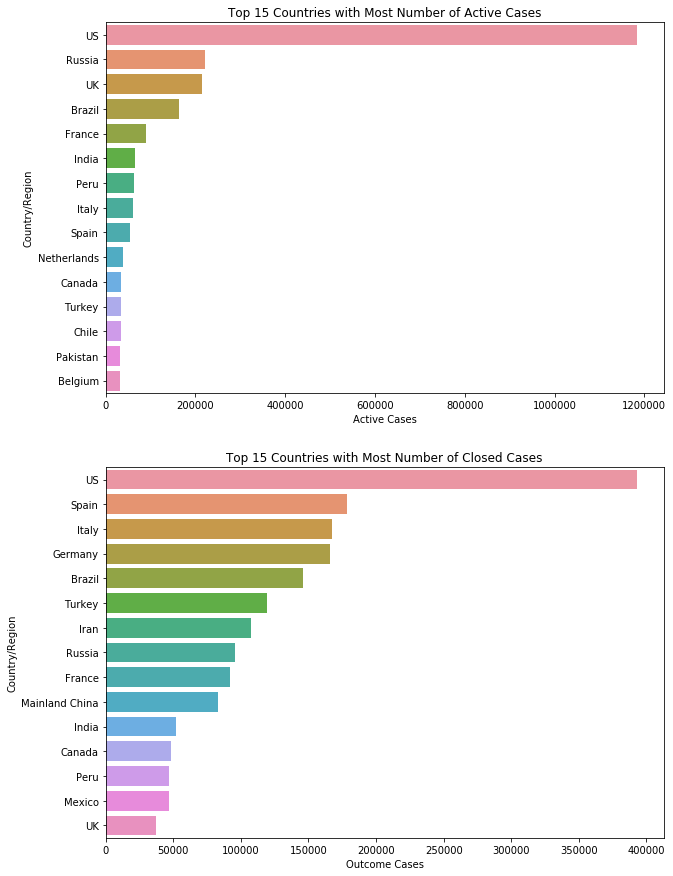

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Active Cases"]=(countrywise["Confirmed"]-countrywise["Recovered"]-countrywise["Deaths"])
countrywise["Outcome Cases"]=(countrywise["Recovered"]+countrywise["Deaths"])
top_15_active=countrywise.sort_values(["Active Cases"],ascending=False).head(15)
top_15_outcome=countrywise.sort_values(["Outcome Cases"],ascending=False).head(15)
sns.barplot(x=top_15_active["Active Cases"],y=top_15_active.index,ax=ax1)
sns.barplot(x=top_15_outcome["Outcome Cases"],y=top_15_outcome.index,ax=ax2)
ax1.set_title("Top 15 Countries with Most Number of Active Cases")
ax2.set_title("Top 15 Countries with Most Number of Closed Cases")

In [30]:
country_date=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
confirm_rate=[]
for country in countrywise.index:
    days=country_date.ix[country].shape[0]
    confirm_rate.append((countrywise[country]["Confirmed"])/days)
countrywise["Confirm Cases/Day"]=confirm_rate

KeyError: 'US'

KeyError: 'Confirm Cases/Day'

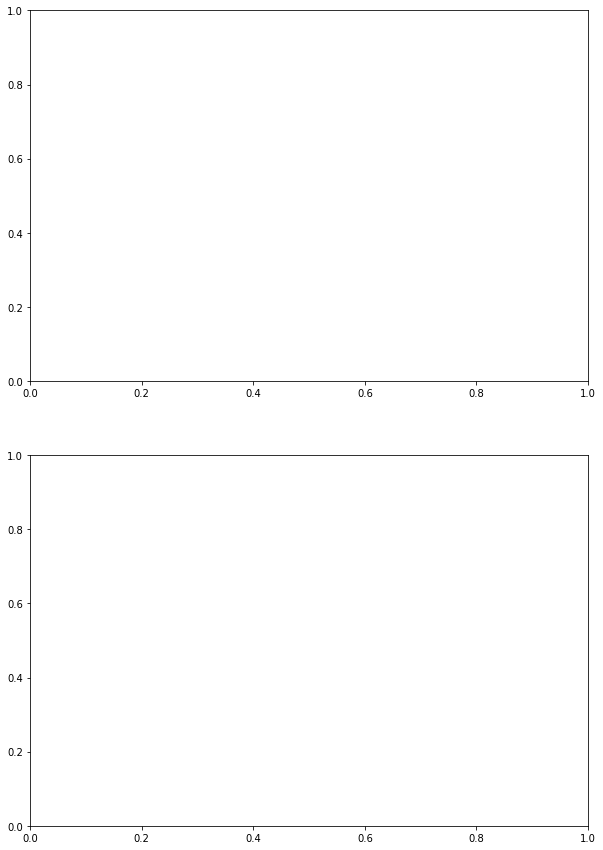

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
top_15_ccpd=countrywise.sort_values(["Confirm Cases/Day"],ascending=False).head(15)
sns.barplot(y=top_15_ccpd.index,x=top_15_ccpd["Confirm Cases/Day"],ax=ax1)
ax1.set_title("Top 15 countries as per high number Confirmed Cases per Day")
bottom_15_ccpd=countrywise[countrywise["Confirmed"]>1000].sort_values(["Confirm Cases/Day"],ascending=False).tail(15)
sns.barplot(y=bottom_15_ccpd.index,x=bottom_15_ccpd["Confirm Cases/Day"],ax=ax2)
ax2.set_title("Top 15 countries as per Lowest Confirmed Cases per Day having more than 1000 Confirmed Cases")

Mean Survival Probability across all countries 96.37421718529109
Median Survival Probability across all countries 97.1969818536794
Mean Death Probability across all countries 3.625782814708913
Median Death Probability across all countries 2.8030181463205963


Text(0.5, 1.0, 'Bottom 15 Countries as per Survival Probability')

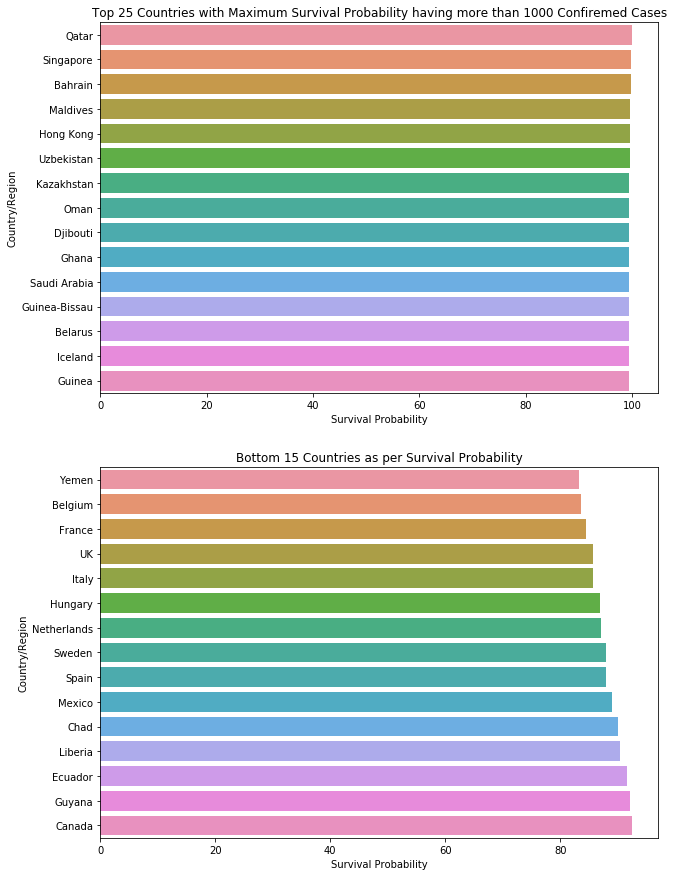

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Survival Probability"]=(1-(countrywise["Deaths"]/countrywise["Confirmed"]))*100
top_25_survival=countrywise[countrywise["Confirmed"]>1000].sort_values(["Survival Probability"],ascending=False).head(15)
sns.barplot(x=top_25_survival["Survival Probability"],y=top_25_survival.index,ax=ax1)
ax1.set_title("Top 25 Countries with Maximum Survival Probability having more than 1000 Confiremed Cases")
print('Mean Survival Probability across all countries',countrywise["Survival Probability"].mean())
print('Median Survival Probability across all countries',countrywise["Survival Probability"].median())
print('Mean Death Probability across all countries',100-countrywise["Survival Probability"].mean())
print('Median Death Probability across all countries',100-countrywise["Survival Probability"].median())

Bottom_5_countries=countrywise[countrywise["Confirmed"]>100].sort_values(["Survival Probability"],ascending=True).head(15)
sns.barplot(x=Bottom_5_countries["Survival Probability"],y=Bottom_5_countries.index,ax=ax2)
plt.title("Bottom 15 Countries as per Survival Probability")

In [32]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [33]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

Text(0.5, 1.0, 'COVID-19 Journey of Top 10 countries having Highest number of Confirmed Cases')

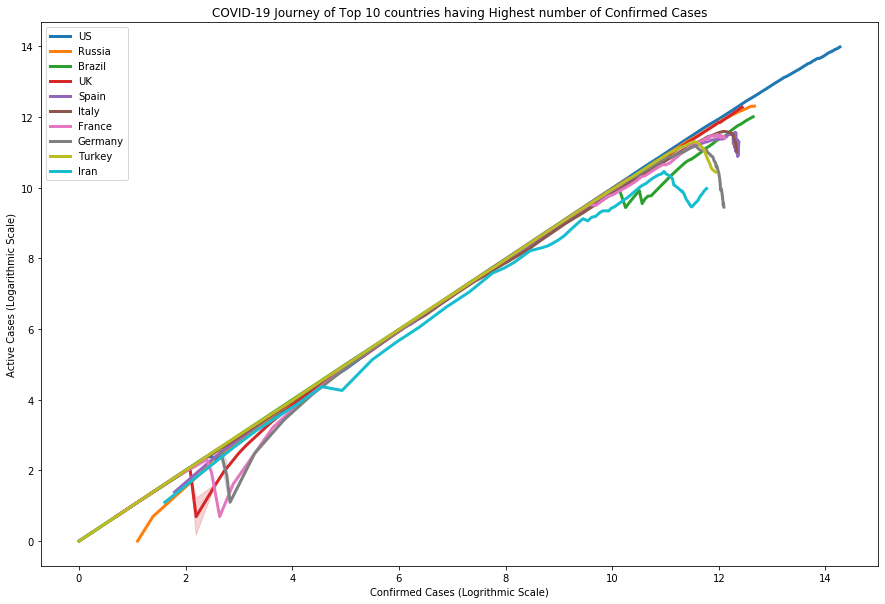

In [34]:
plt.figure(figsize=(15,10))
for country in countrywise.head(10).index:
    sns.lineplot(x=grouped_country.ix[country]["log_confirmed"],y=grouped_country.ix[country]["log_active"],
                 label=country,linewidth=3)
plt.xlabel("Confirmed Cases (Logrithmic Scale)")
plt.ylabel("Active Cases (Logarithmic Scale)")
plt.title("COVID-19 Journey of Top 10 countries having Highest number of Confirmed Cases")

## Clustering of Countries

In [35]:
X=countrywise[["Mortality","Recovery"]]
#Standard Scaling since K-Means Clustering is a distance based alogrithm
X=std.fit_transform(X) 

In [36]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Silhouette Score Method')

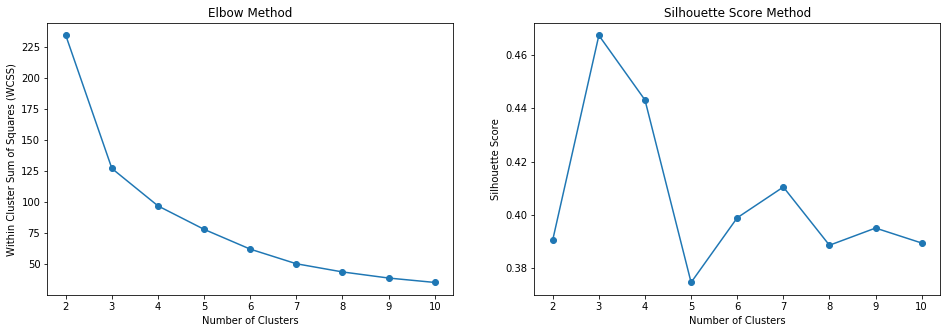

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,11)
ax1.plot(x,wcss,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,11)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

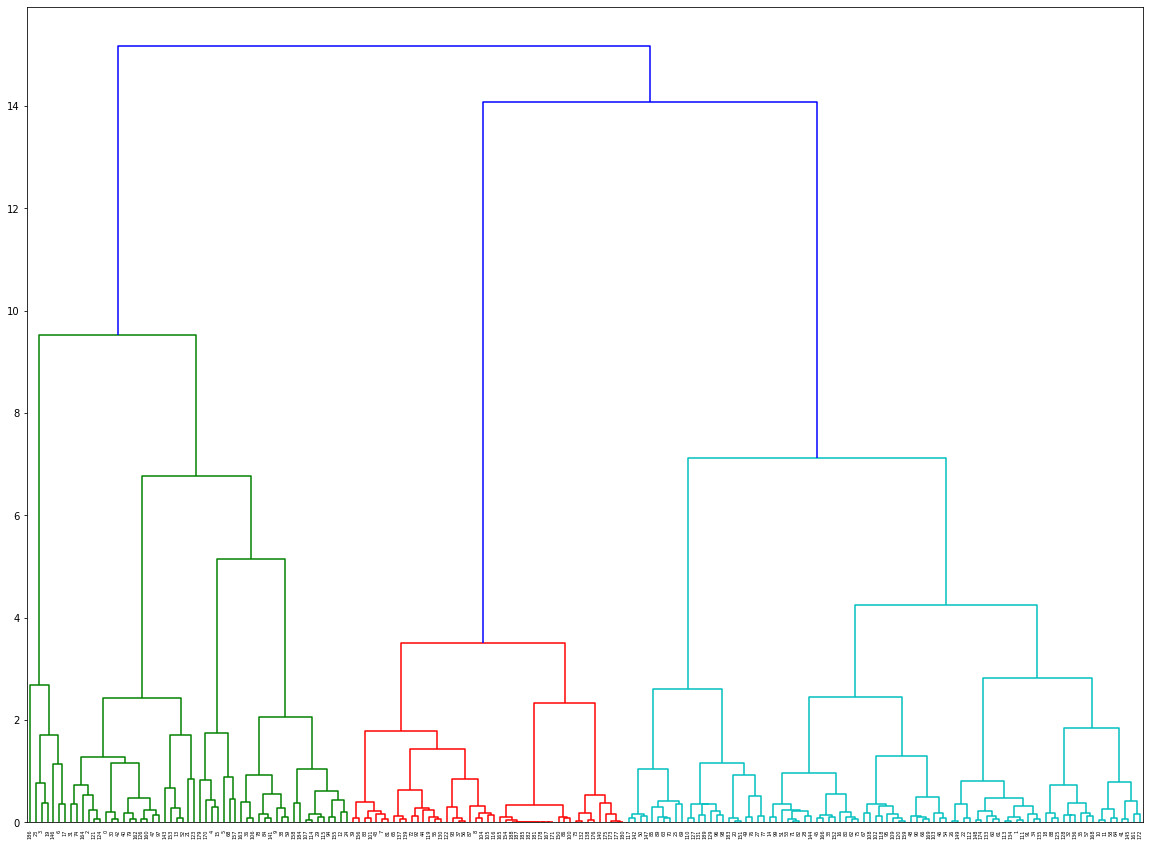

In [38]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,15))
dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))

All the three methods namely Elbow Method, Silhouette Score and Hierarchical Clustering shows **K=3** will correct number of clusters.

In [39]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=6, tol=0.0001, verbose=0)

In [40]:
countrywise["Clusters"]=clf_final.predict(X)

#### Summary of Clusters

In [41]:
cluster_summary=pd.concat([countrywise[countrywise["Clusters"]==1].head(15),countrywise[countrywise["Clusters"]==2].head(15),countrywise[countrywise["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Reds').format("{:.2f}")

In [42]:
print("Avergae Mortality Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Recovery"].mean())

Avergae Mortality Rate of Cluster 0:  2.703285956626713
Avergae Recovery Rate of Cluster 0:  81.58994561366262
Avergae Mortality Rate of Cluster 1:  2.386842284847858
Avergae Recovery Rate of Cluster 1:  29.88226570888213
Avergae Mortality Rate of Cluster 2:  11.921695160280114
Avergae Recovery Rate of Cluster 2:  40.20712156909569


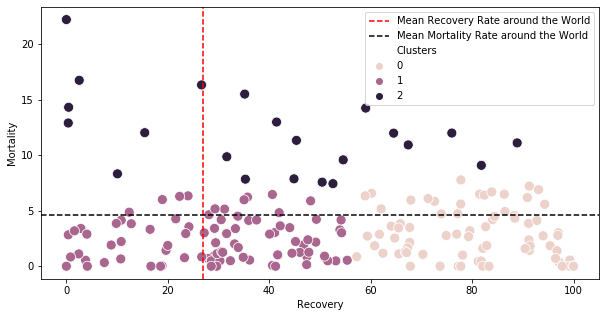

In [43]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
plt.axvline(((datewise["Recovered"]/datewise["Confirmed"])*100).mean(),
            color='red',linestyle="--",label="Mean Recovery Rate around the World")
plt.axhline(((datewise["Deaths"]/datewise["Confirmed"])*100).mean(),
            color='black',linestyle="--",label="Mean Mortality Rate around the World")
plt.legend()

In [44]:
print("Few Countries belonging to Cluster 0: ",list(countrywise[countrywise["Clusters"]==0].head(10).index))
print("Few Countries belonging to Cluster 1: ",list(countrywise[countrywise["Clusters"]==1].head(10).index))
print("Few Countries belonging to Cluster 2: ",list(countrywise[countrywise["Clusters"]==2].head(10).index))

Few Countries belonging to Cluster 0:  ['Germany', 'Turkey', 'Iran', 'Mainland China', 'Switzerland', 'Ireland', 'Romania', 'Israel', 'Japan', 'Austria']
Few Countries belonging to Cluster 1:  ['US', 'Russia', 'Brazil', 'India', 'Peru', 'Saudi Arabia', 'Chile', 'Pakistan', 'Qatar', 'Belarus']
Few Countries belonging to Cluster 2:  ['UK', 'Spain', 'Italy', 'France', 'Canada', 'Mexico', 'Belgium', 'Netherlands', 'Ecuador', 'Sweden']


Cluster 0 is a set of countries which have really **High Mortality Rate** and consdierably **Good Recovery Rate**. Basically few countries among these clusters have seen already the worst of this pandemic but are now recovering with healty Recovery Rate.

Cluster 1 is set of countries which have **Low Mortality Rate** and really **High Recovery Rate**. These are the set of countries who has been able to control the COVID-19 by following pandemic controlling practices rigorously. 

Cluster 2 is set of countries which have **Low Mortality Rate** and really **Low Recovery Rate**. These countries need to pace up their Revovery Rate to get out it, Some thses countries have really high number of Infected Cases but Low Mortality is positive sign out of it.

### Comparison of China, Italy, US, Spain and Rest of the World

In [45]:
china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
US_data=covid[covid["Country/Region"]=="US"]
spain_data=covid[covid["Country/Region"]=="Spain"]
brazil_data=covid[covid["Country/Region"]=="Brazil"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Italy")&(covid["Country/Region"]!="US")&(covid["Country/Region"]!="Spain")&(covid["Country/Region"]!="Brazil")]

datewise_china=china_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_US=US_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Spain=spain_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Brazil=brazil_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

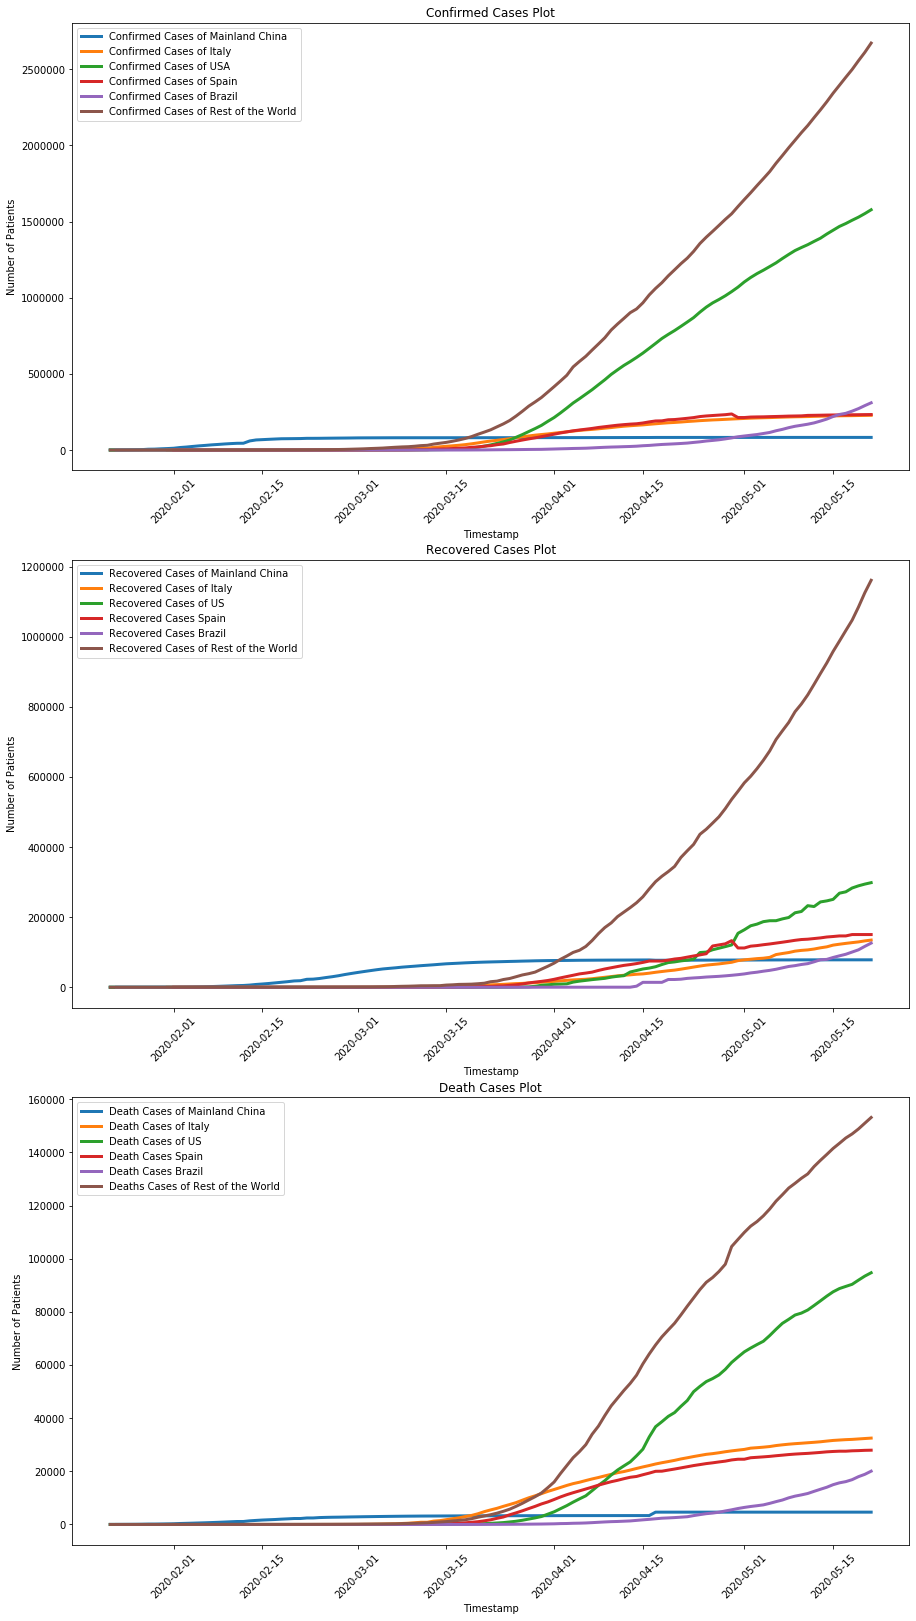

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,28))
ax1.plot(datewise_china["Confirmed"],label="Confirmed Cases of Mainland China",linewidth=3)
ax1.plot(datewise_Italy["Confirmed"],label="Confirmed Cases of Italy",linewidth=3)
ax1.plot(datewise_US["Confirmed"],label="Confirmed Cases of USA",linewidth=3)
ax1.plot(datewise_Spain["Confirmed"],label="Confirmed Cases of Spain",linewidth=3)
ax1.plot(datewise_Brazil["Confirmed"],label="Confirmed Cases of Brazil",linewidth=3)
ax1.plot(datewise_restofworld["Confirmed"],label="Confirmed Cases of Rest of the World",linewidth=3)
ax1.set_title("Confirmed Cases Plot")
ax1.set_ylabel("Number of Patients")
ax1.set_xlabel("Timestamp")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax2.plot(datewise_china["Recovered"],label="Recovered Cases of Mainland China",linewidth=3)
ax2.plot(datewise_Italy["Recovered"],label="Recovered Cases of Italy",linewidth=3)
ax2.plot(datewise_US["Recovered"],label="Recovered Cases of US",linewidth=3)
ax2.plot(datewise_Spain["Recovered"],label="Recovered Cases Spain",linewidth=3)
ax2.plot(datewise_Brazil["Recovered"],label="Recovered Cases Brazil",linewidth=3)
ax2.plot(datewise_restofworld["Recovered"],label="Recovered Cases of Rest of the World",linewidth=3)
ax2.set_title("Recovered Cases Plot")
ax2.set_ylabel("Number of Patients")
ax2.set_xlabel("Timestamp")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax3.plot(datewise_china["Deaths"],label='Death Cases of Mainland China',linewidth=3)
ax3.plot(datewise_Italy["Deaths"],label='Death Cases of Italy',linewidth=3)
ax3.plot(datewise_US["Deaths"],label='Death Cases of US',linewidth=3)
ax3.plot(datewise_Spain["Deaths"],label='Death Cases Spain',linewidth=3)
ax3.plot(datewise_Brazil["Deaths"],label='Death Cases Brazil',linewidth=3)
ax3.plot(datewise_restofworld["Deaths"],label="Deaths Cases of Rest of the World",linewidth=3)
ax3.set_title("Death Cases Plot")
ax3.set_ylabel("Number of Patients")
ax3.set_xlabel("Timestamp")
ax3.legend()
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)

In [47]:
datewise_china["Mortality"]=(datewise_china["Deaths"]/datewise_china["Confirmed"])*100
datewise_Italy["Mortality"]=(datewise_Italy["Deaths"]/datewise_Italy["Confirmed"])*100
datewise_US["Mortality"]=(datewise_US["Deaths"]/datewise_US["Confirmed"])*100
datewise_Spain["Mortality"]=(datewise_Spain["Deaths"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Mortality"]=(datewise_Brazil["Deaths"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Mortality"]=(datewise_restofworld["Deaths"]/datewise_restofworld["Confirmed"])*100

datewise_china["Recovery"]=(datewise_china["Recovered"]/datewise_china["Confirmed"])*100
datewise_Italy["Recovery"]=(datewise_Italy["Recovered"]/datewise_Italy["Confirmed"])*100
datewise_US["Recovery"]=(datewise_US["Recovered"]/datewise_US["Confirmed"])*100
datewise_Spain["Recovery"]=(datewise_Spain["Recovered"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Recovery"]=(datewise_Brazil["Recovered"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Recovery"]=(datewise_restofworld["Recovered"]/datewise_restofworld["Confirmed"])*100

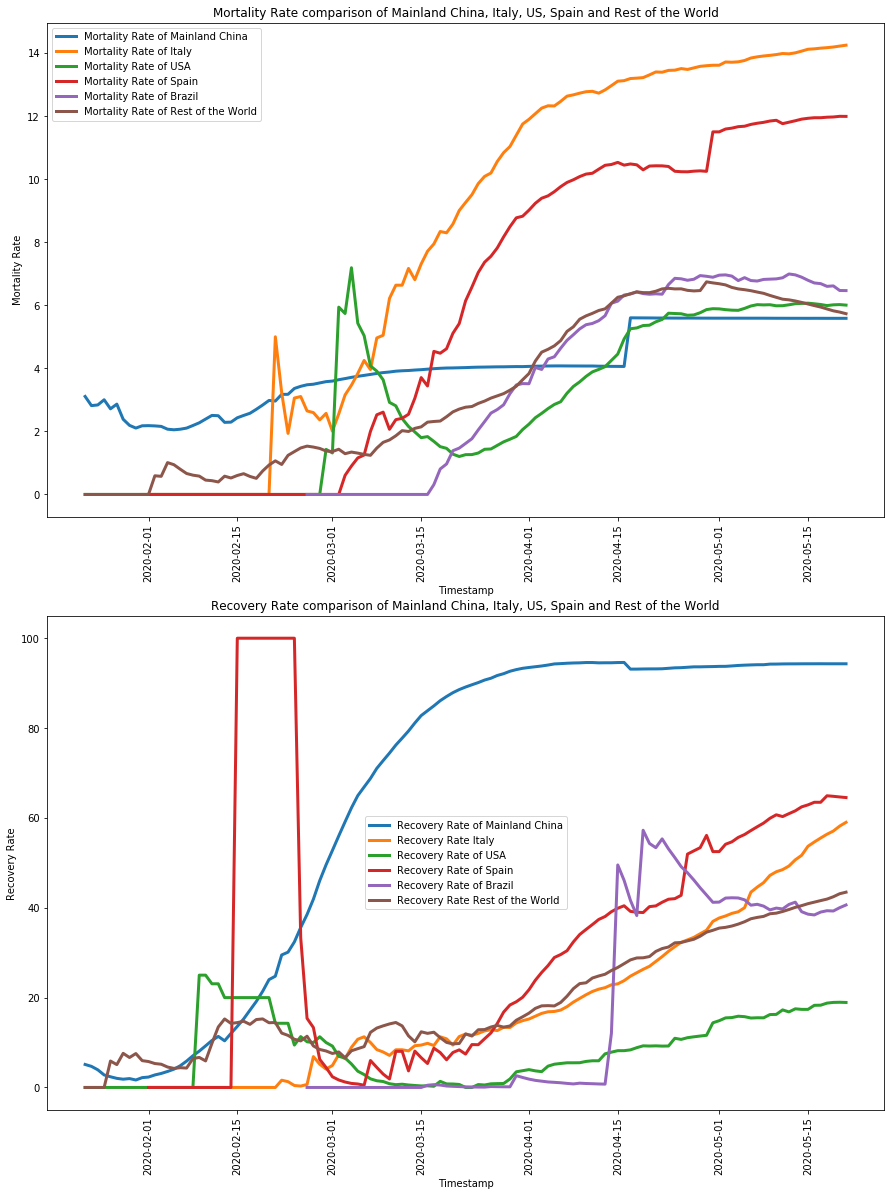

In [48]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(15,20))
ax1.plot(datewise_china["Mortality"],label="Mortality Rate of Mainland China",linewidth=3)
ax1.plot(datewise_Italy["Mortality"],label="Mortality Rate of Italy",linewidth=3)
ax1.plot(datewise_US["Mortality"],label="Mortality Rate of USA",linewidth=3)
ax1.plot(datewise_Spain["Mortality"],label="Mortality Rate of Spain",linewidth=3)
ax1.plot(datewise_Brazil["Mortality"],label="Mortality Rate of Brazil",linewidth=3)
ax1.plot(datewise_restofworld["Mortality"],label="Mortality Rate of Rest of the World",linewidth=3)
ax1.set_ylabel("Mortality Rate")
ax1.set_xlabel("Timestamp")
ax1.set_title("Mortality Rate comparison of Mainland China, Italy, US, Spain and Rest of the World")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.plot(datewise_china["Recovery"],label="Recovery Rate of Mainland China",linewidth=3)
ax2.plot(datewise_Italy["Recovery"],label="Recovery Rate Italy",linewidth=3)
ax2.plot(datewise_US["Recovery"],label="Recovery Rate of USA",linewidth=3)
ax2.plot(datewise_Spain["Recovery"],label="Recovery Rate of Spain",linewidth=3)
ax2.plot(datewise_Brazil["Recovery"],label="Recovery Rate of Brazil",linewidth=3)
ax2.plot(datewise_restofworld["Recovery"],label="Recovery Rate Rest of the World",linewidth=3)
ax2.set_ylabel("Recovery Rate")
ax2.set_xlabel("Timestamp")
ax2.set_title("Recovery Rate comparison of Mainland China, Italy, US, Spain and Rest of the World")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

#### Taking off Recovery Rate of Spain is a good sign but it's nowhere in comparison to the Moratality Rate.
#### Its alarming sign for USA and Brazil as their Recovery Rate is improving considerably as compared to other severly affected countries.

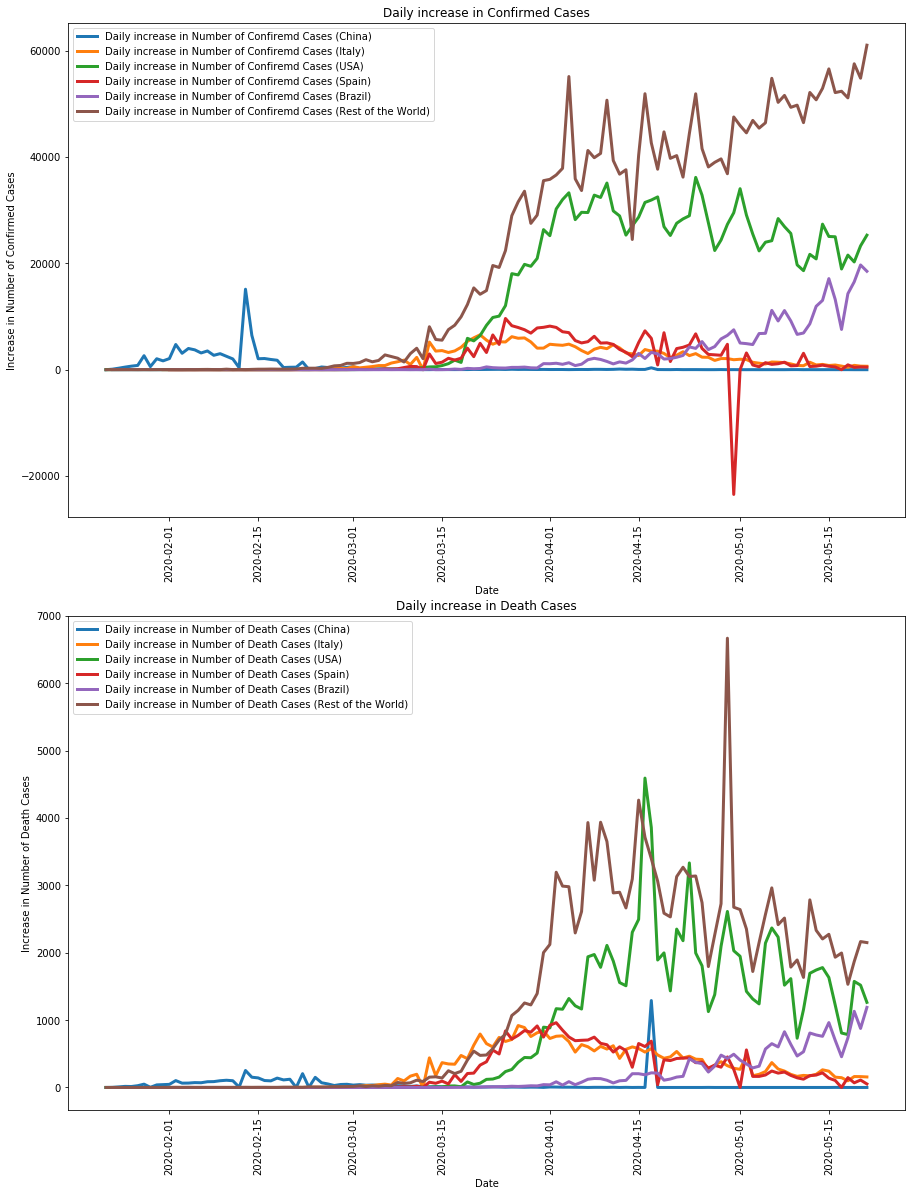

In [49]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(15,20))
ax1.plot(datewise_china["Confirmed"].diff().fillna(0),label='Daily increase in Number of Confiremd Cases (China)',linewidth=3)
ax1.plot(datewise_Italy["Confirmed"].diff().fillna(0),label='Daily increase in Number of Confiremd Cases (Italy)',linewidth=3)
ax1.plot(datewise_US["Confirmed"].diff().fillna(0),label='Daily increase in Number of Confiremd Cases (USA)',linewidth=3)
ax1.plot(datewise_Spain["Confirmed"].diff().fillna(0),label='Daily increase in Number of Confiremd Cases (Spain)',linewidth=3)
ax1.plot(datewise_Brazil["Confirmed"].diff().fillna(0),label='Daily increase in Number of Confiremd Cases (Brazil)',linewidth=3)
ax1.plot(datewise_restofworld["Confirmed"].diff().fillna(0),label='Daily increase in Number of Confiremd Cases (Rest of the World)',linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel("Increase in Number of Confirmed Cases")
ax1.set_title("Daily increase in Confirmed Cases")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.plot(datewise_china["Deaths"].diff().fillna(0),label='Daily increase in Number of Death Cases (China)',linewidth=3)
ax2.plot(datewise_Italy["Deaths"].diff().fillna(0),label='Daily increase in Number of Death Cases (Italy)',linewidth=3)
ax2.plot(datewise_US["Deaths"].diff().fillna(0),label='Daily increase in Number of Death Cases (USA)',linewidth=3)
ax2.plot(datewise_Spain["Deaths"].diff().fillna(0),label='Daily increase in Number of Death Cases (Spain)',linewidth=3)
ax2.plot(datewise_Brazil["Deaths"].diff().fillna(0),label='Daily increase in Number of Death Cases (Brazil)',linewidth=3)
ax2.plot(datewise_restofworld["Deaths"].diff().fillna(0),label='Daily increase in Number of Death Cases (Rest of the World)',linewidth=3)
ax2.set_xlabel('Date')
ax2.set_ylabel("Increase in Number of Death Cases")
ax2.set_title("Daily increase in Death Cases")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

#### We can clearly notice the decreasing trend in the number of Daily Confirmed and Death Cases of Spain and Italy. That's really positive sign for both the countries. 

## Prediction using Machine Learning Models

#### Linear Regression Model for Confirm Cases Prediction

In [64]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [65]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [66]:
lin_reg=LinearRegression(normalize=True)

In [67]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [68]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [69]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  1396881.931752011


In [70]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### The Linear Regression Model is absolutely falling aprat. As it is clearly visible that the trend of Confirmed Cases in absolutely not Linear.

#### Polynomial Regression for Prediction of Confirmed Cases

In [71]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [72]:
poly = PolynomialFeatures(degree = 8) 

In [73]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [74]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [75]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  79624.53553545529


In [76]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [77]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

#### Support Vector Machine ModelRegressor for Prediction of Confirmed Cases 

In [78]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [79]:
#Intializing SVR Model
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

In [80]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [81]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [82]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  457264.63458468625


In [83]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [84]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [85]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

Dates  Linear Regression Prediction  Polynonmial Regression Prediction  \
0 2020-05-22                3571669.076260                     4967581.898007   
1 2020-05-23                3609578.157818                     4980051.138796   
2 2020-05-24                3647487.239375                     4970643.609929   
3 2020-05-25                3685396.320933                     4935063.251414   
4 2020-05-26                3723305.402491                     4868454.403181   

   SVM Prediction  
0  6111266.395915  
1  6364008.868926  
2  6625175.227955  
3  6894974.315592  
4  7173618.397960

Predictions of Linear Regression are nowhere close to actual values.

## Time Series Forecasting 

#### Holt's Linear Model

In [86]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]

In [87]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.1, smoothing_slope=1.1,optimized=False)
y_pred=valid.copy()

In [88]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  8727.48784602069


In [89]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [90]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

Dates  Linear Regression Prediction  Polynonmial Regression Prediction  \
0 2020-05-22                3571669.076260                     4967581.898007   
1 2020-05-23                3609578.157818                     4980051.138796   
2 2020-05-24                3647487.239375                     4970643.609929   
3 2020-05-25                3685396.320933                     4935063.251414   
4 2020-05-26                3723305.402491                     4868454.403181   

   SVM Prediction  Holt's Linear Model Prediction  
0  6111266.395915                  5185050.171547  
1  6364008.868926                  5277357.157595  
2  6625175.227955                  5369664.143644  
3  6894974.315592                  5461971.129692  
4  7173618.397960                  5554278.115741

#### Holt's Winter Model for Daily Time Series

In [91]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [92]:
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=5,trend='mul', seasonal='mul').fit()

In [93]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))

In [94]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  13189.244459053132


In [95]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [96]:
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

Dates  Linear Regression Prediction  Polynonmial Regression Prediction  \
0 2020-05-22                3571669.076260                     4967581.898007   
1 2020-05-23                3609578.157818                     4980051.138796   
2 2020-05-24                3647487.239375                     4970643.609929   
3 2020-05-25                3685396.320933                     4935063.251414   
4 2020-05-26                3723305.402491                     4868454.403181   

   SVM Prediction  Holt's Linear Model Prediction  \
0  6111266.395915                  5185050.171547   
1  6364008.868926                  5277357.157595   
2  6625175.227955                  5369664.143644   
3  6894974.315592                  5461971.129692   
4  7173618.397960                  5554278.115741   

   Holt's Winter Model Prediction  
0                  5206723.595269  
1                  5315229.034149  
2                  5420069.137739  
3                  5519883.314651  
4                  5633349.418807

In [97]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

### Facebook's Prophet Model for forecasting 

In [111]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

In [112]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [113]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [115]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [116]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  12065.588523893863


Figure(720x432)


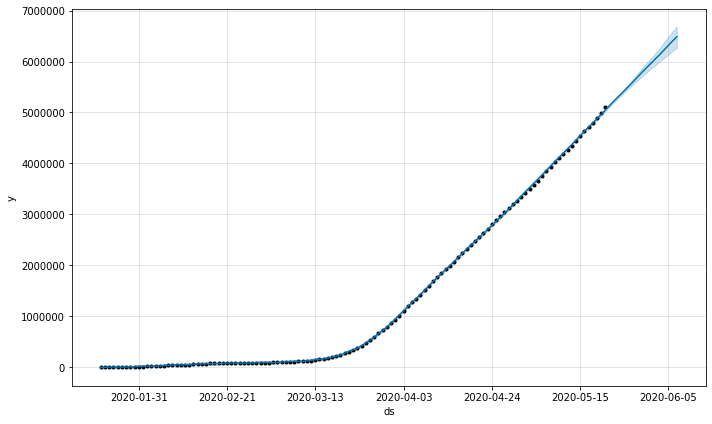

In [117]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


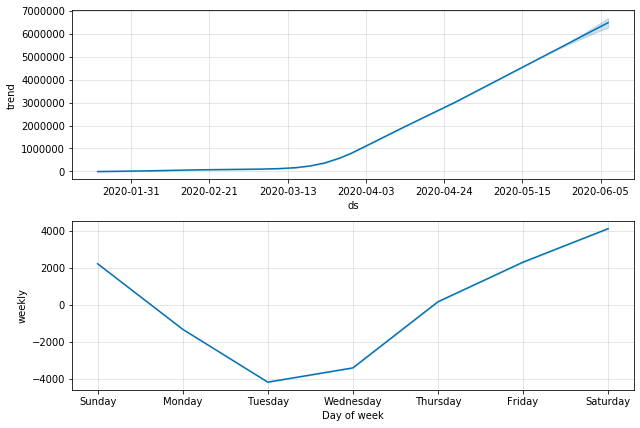

In [118]:
print(prophet_c.plot_components(confirmed_forecast))

#### Summarization of Forecasts using different Models

In [119]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

Model Name  Root Mean Squared Error
3                     Holt's Linear              8727.487846
5        Auto Regressive Model (AR)             12065.588524
4               Holt's Winter Model             13189.244459
1             Polynomial Regression             79624.535535
2  Support Vector Machine Regressor            457264.634585
0                 Linear Regression           1396881.931752

In [120]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(17))
model_predictions.head()

Dates  Linear Regression Prediction  Polynonmial Regression Prediction  \
0 2020-05-22                3571669.076260                     4967581.898007   
1 2020-05-23                3609578.157818                     4980051.138796   
2 2020-05-24                3647487.239375                     4970643.609929   
3 2020-05-25                3685396.320933                     4935063.251414   
4 2020-05-26                3723305.402491                     4868454.403181   

   SVM Prediction  Holt's Linear Model Prediction  \
0  6111266.395915                  5185050.171547   
1  6364008.868926                  5277357.157595   
2  6625175.227955                  5369664.143644   
3  6894974.315592                  5461971.129692   
4  7173618.397960                  5554278.115741   

   Holt's Winter Model Prediction  Prophet's Prediction  Prophet's Upper Bound  
0                  5206723.595269        5134070.996196         5158555.484940  
1                  5315229.034149        5220375.931589         5244545.096134  
2                  5420069.137739        5302973.687739         5332459.157673  
3                  5519883.314651        5383921.122666         5413940.385715  
4                  5633349.418807        5465553.885292         5502257.208648

### Time Series Forecasting for Death Cases

In [121]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [122]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

COVID-19 doesn't have very high mortatlity rate as we can see which is the most positive take away. Also the healthy Recovery Rate implies the disease is cureable. The only matter of concern is the exponential growth rate of infection. 

Countries like USA, Spain, United Kingdom,and Italy are facing some serious trouble in containing the disease showing how deadly the neglegence can lead to. The need of the hour is to perform COVID-19 pendemic controlling practices like Testing, Contact Tracing and Quarantine with a speed greater than the speed of disease spread at each country level.

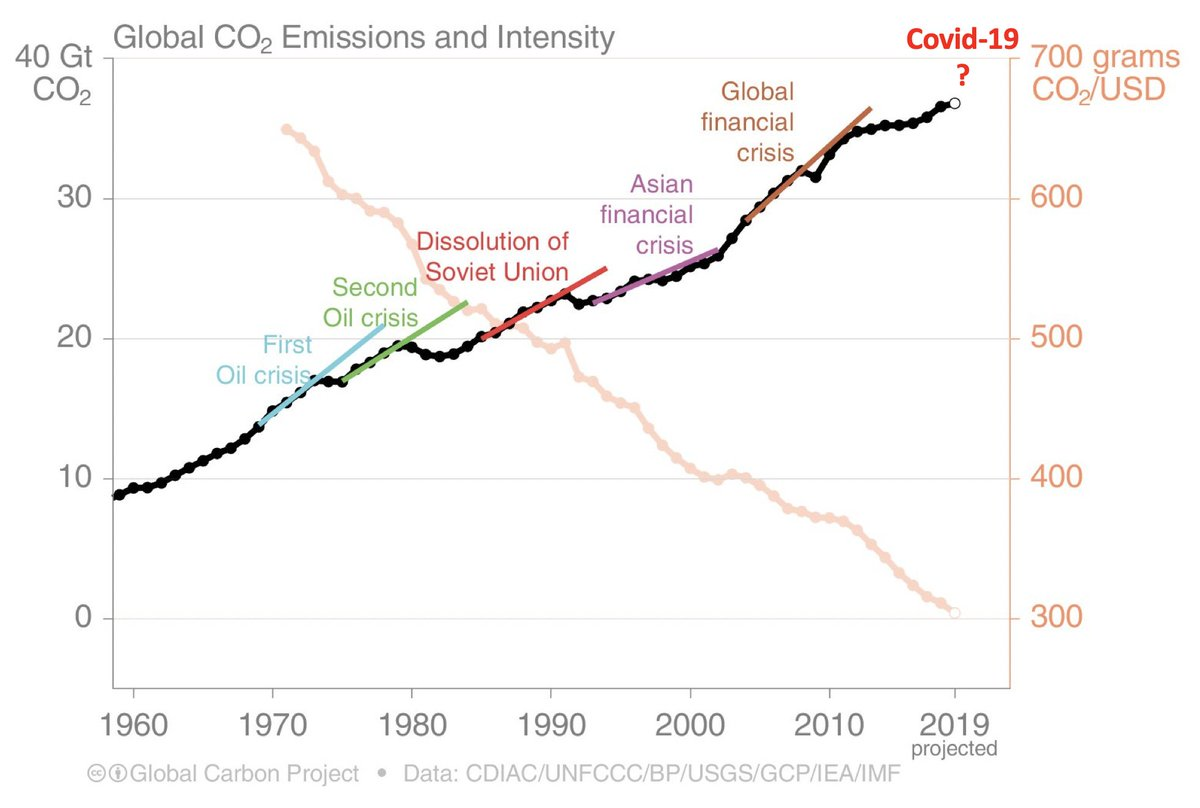

The reason of putting this graph in the conclusion, there is an interesting pattern to observe here, Everytime there has been drop in World's Carbon emission, the world economy crashed. A one classic example is 2008 recession. I think most of you must have already guessed what's ahead, probably COVID-19 is just a big wave with a Tsunami of Recession or Depression following it. 

The growth of Confirmed and Death Cases seems to have slowed down since past few days. Which is really good sign. Hope this goes like that for a brief period. There should not be any new country emerging as the new epicenter of COVID-19 just like USA happened to be that epicenter for brief period. In case if any new country emerges as new epicenter, the Growth of Confirmed Cases will shoot up again.

### Will be updating the notebook with new Data Visualization Plot and new Prediction and Forecasting Models. Please upvote the kernel if you have liked the work. Also, any kind of suggestion and corrections would be highly appreciated!

## Stay Safe and follow basic hygiene Practices!